## Initialization

In [4]:
import pickle
import numpy as np
import pandas as pd
import datetime as dt

C:\Users\user\AppData\Local\Temp\ipykernel_33864\3627370670.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### CPU Utilization

<Axes: >

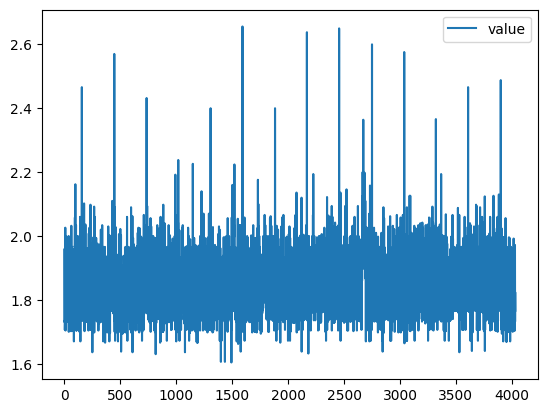

In [32]:
cpu = pd.read_csv('data/Numenta Anomaly Benchmark (NAB)/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv')
cpu.head(1)
cpu.plot()

#### Network Usage

<Axes: >

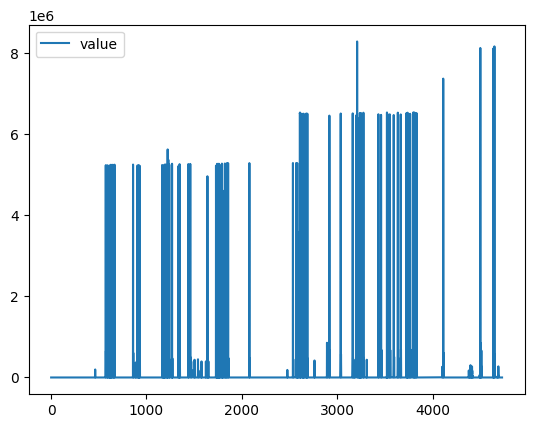

In [6]:
network = pd.read_csv('data/Numenta Anomaly Benchmark (NAB)/realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_5abac7.csv')
network.plot()

#### Travel Time

<Axes: >

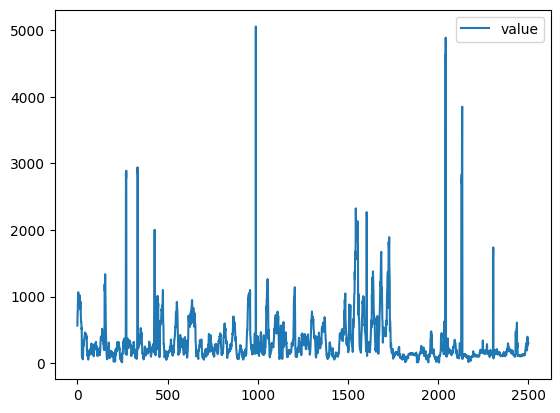

In [7]:
traffic = pd.read_csv('data/Numenta Anomaly Benchmark (NAB)/realTraffic/realTraffic/TravelTime_387.csv')
traffic.plot()

#### Twitter Volume

<Axes: >

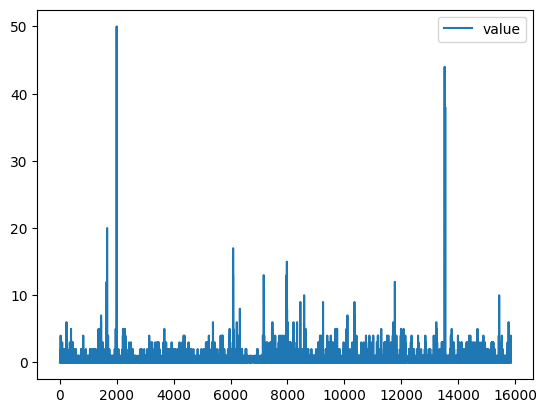

In [8]:
twitter = pd.read_csv('data/Numenta Anomaly Benchmark (NAB)/realTweets/realTweets/Twitter_volume_CVS.csv')
twitter.plot()

## Streaming Anomaly Detection
- Streaming MA
- Streaming EA

### Plot Function

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def plot_anomalies(dfs, algorithm, parameters, title=False, dumping=False):
    '''Plot the Streaming Data (an Anomalies)'''
    n = len(dfs)
    lin, col = 1, 1
    for i in range(1, n+1):
        if lin * col < i:
            if lin == col: col += 1
            else: lin += 1
    # create a subplot
    model_name = algorithm.__name__
    fig, axes = plt.subplots(lin, col, squeeze=False, sharex=False, sharey=False, figsize=(col*4.5, lin*3))
    fig.suptitle(f'Anomaly Detection - {model_name}')
    xlin, xcol = 0, 0
    for i, df in enumerate(dfs):
        # get data 
        get_timestamp = lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()
        X = df.timestamp.apply(lambda x: int(get_timestamp(x)))
        Y = df.value
        # predict anomalies
        model = algorithm(**parameters)
        preds = [model.detect(i, v, dumping=True) for i, v in zip(X, Y)]
        pred, values, stds = tuple(zip(*preds))
        # plot the results
        af  = pd.DataFrame(data={'x':X, 'value':Y, 'pred':pred})
        af2 = pd.DataFrame(data={'x':X, 'value':values, 'pred':pred, 'std': stds})
        af2['ymin'] = af2['value'] - af2['std']
        af2['ymax'] = af2['value'] + af2['std']
        size = 20  # af.pred.astype(int) *
        sns.lineplot(ax=axes[xlin, xcol], data=af, x='x', y='value')
        sns.scatterplot(ax=axes[xlin, xcol], data=af, x='x', y='value', hue='pred', s=size, legend='full')
        if dumping: axes[xlin, xcol].fill_between(af2.x, af2.value, af2.ymax, facecolor='green', alpha=0.2)
        if title: axes[xlin, xcol].set_title(f'{title[i]}')
        # update posix
        xlin += 1
        if xlin == lin: xlin,xcol = 0, xcol+1
    plt.tight_layout()
    plt.show()

## Moving Average

**Moving Average** is the most common type of average used in Time Series problems. We perform the sum of recent data points and divide them by the time period. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

In [23]:
class StreamingMovingAverage:

    '''Moving Average algorithm'''
    def __init__(self, threshold=1.5) -> None:
        # parameters
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 3
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def detect(self, timestamp: int, value: float, dumping: bool=False) -> bool:
        '''Detect if is a Anomaly'''
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        response, curr_value, deviation = False, value, 0.0
        if self._enough_data() and not np.isnan(expected_value):
            # is the value out of the boundary ? when it decrease
            curr_value = expected_value
            deviation = self._standard_deviation() * self.max_deviation_from_expected
            # when it is higher than expected
            if expected_value + deviation < value:
                response = True
        # dumping or not
        if dumping: return (response, curr_value, deviation)
        else: return response

    def _update_state(self, timestamp: int, value: float) -> None:
        '''Update the model state'''
        # check if it is the first time the model is run or if there is a big interval between the timestamps
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # update the model state
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # is there a lot of data? remove on record
        if len(self.data_streaming) > self.max_nof_records_in_model:
            self.data_streaming.pop(0)

    def _init_state(self, timestamp: int) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self.data_streaming = list()

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        data = self.data_streaming
        return np.std(data, axis=0)

    def get_state(self) -> dict:
        '''Get the state'''
        self_dict = {key: value for key, value in self.__dict__.items()}
        return pickle.dumps(self_dict, 4)

    def set_state(self, state) -> None:
        '''Set the state'''
        _self = self
        ad = pickle.loads(state)
        for key, value in ad.items():
            setattr(_self, key, value)

How many anomalies we can find with alpha = 2.0 (standard deviation)
- This is a decent number for initial guess

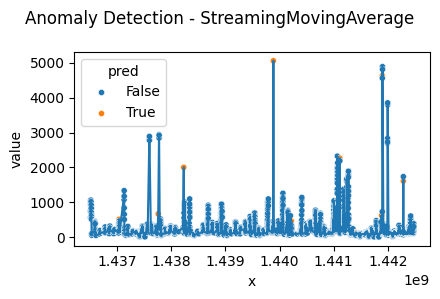

In [24]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2.0}
plot_anomalies([traffic], algorithm, parameters)

How many anomalies we can find with alpha = 1.0 (standard deviation)?
- we guess more anomalies

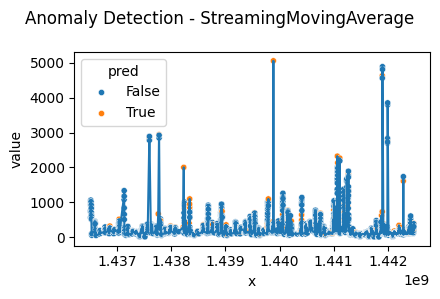

In [25]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 1.0}
plot_anomalies([traffic], algorithm, parameters)

We can also `dumping` to see the expected value range, see:
- **Note** - the value is an anomaly if it is larger than expected

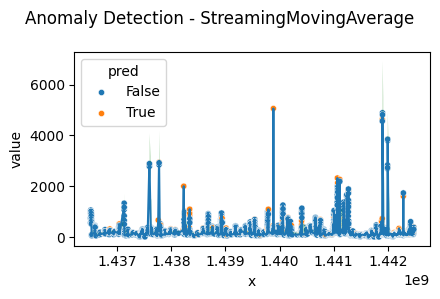

In [26]:
plot_anomalies([traffic], algorithm, parameters, dumping=True)

Let's zoom in on a sample of traffic data.

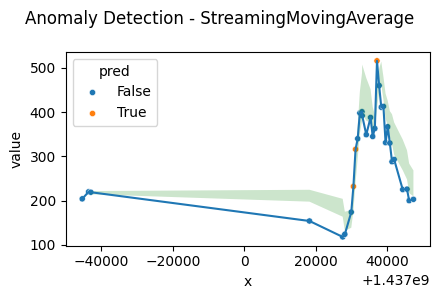

In [27]:
sample = traffic.iloc[120:150]
plot_anomalies([sample], algorithm, parameters, dumping=True)

### Exploring All Data
- You can see that the Moving Average is not smoothing the expected values for most of the problems
- not sensitive to rapid changes
- delay in reaction to anomalies
  

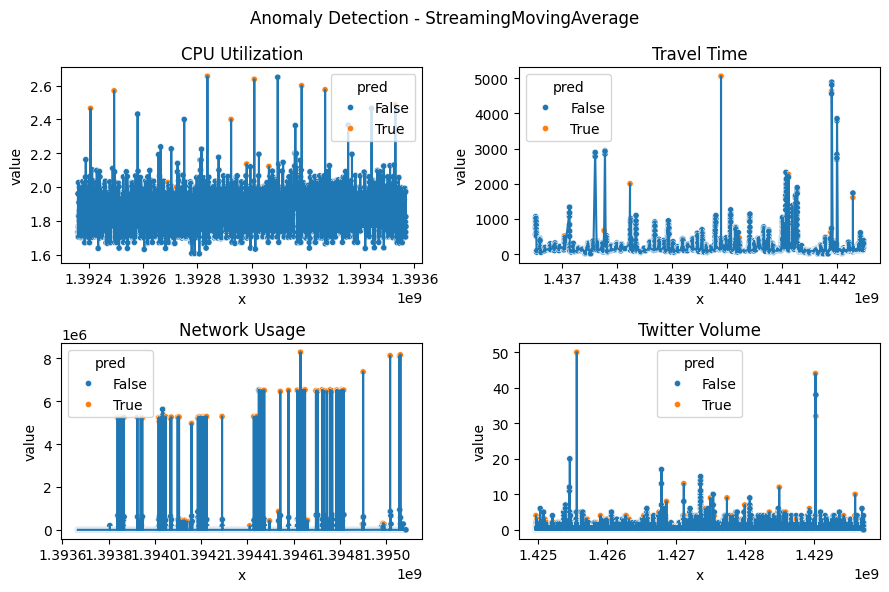

In [28]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2.0}
title = ['CPU Utilization', 'Network Usage', 'Travel Time', 'Twitter Volume']
plot_anomalies([cpu, network, traffic, twitter], algorithm, parameters, title)

## Exponential Moving Average

**Exponential Moving Average** focuses more on recent data by assigning more weight to new data points; so they are weighted by timestamp - most recent has more importance. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `Exponential Moving Average  + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

Alo, the Exponential Moving Average needs a parameter called `alpha` that determines the importance of the last record, and its value is decreased for the next records. For example, if `alpha=0.5`: the record-1 has 50% of importance, the record-2 has 30% of importance, and so on. Thus, this weigted algorithm enables smooth the expected reason

In [29]:
class StreamingExponentialMovingAverage(StreamingMovingAverage):
    '''Exponential Weighted Moving Average (EWMA) algorithm'''
    def __init__(self, threshold=1.5, alpha=0.3) -> None:
        super().__init__()
        # Parameters
        self.max_deviation_from_expected = threshold
        self.alpha = alpha

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) > 0

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        return data.ewm(alpha=self.alpha, adjust=True).mean().iloc[-1]
        

Let's try to reproduce the Moving Average anomalies in Travel Time dataset.
- we found that params `threshold=1.5` and `alpha=0.5`

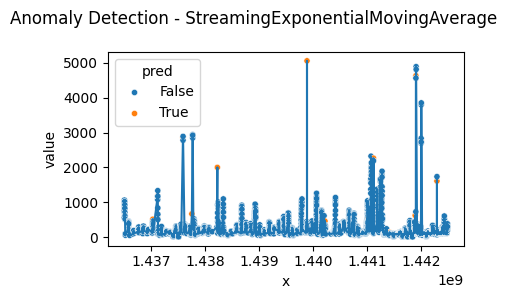

In [33]:
algorithm = StreamingExponentialMovingAverage
parameters = {'threshold': 1.5, 'alpha': 0.5}
plot_anomalies([traffic], algorithm, parameters)

Comparing _Moving Average_ with _Exponential Moving Average_, we can noticed that Exponential smoothes the expected value and avoids detecting unnecessary outliers.

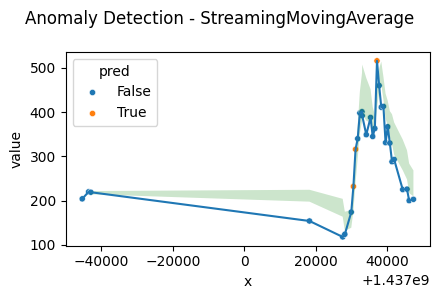

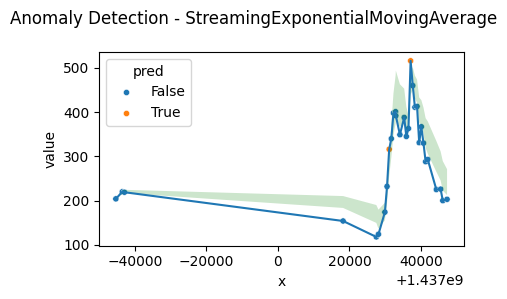

In [34]:
sample = traffic.iloc[120:150]

algorithm = StreamingMovingAverage
parameters = {'threshold': 1.0}
plot_anomalies([sample], algorithm, parameters, dumping=True)

algorithm = StreamingExponentialMovingAverage
parameters = {'threshold': 1.0, 'alpha': 0.5}
plot_anomalies([sample], algorithm, parameters, dumping=True)

### Exploring All Data
- EMA is smoothing the expected values
- this algo highlights only anomalies with gross changes

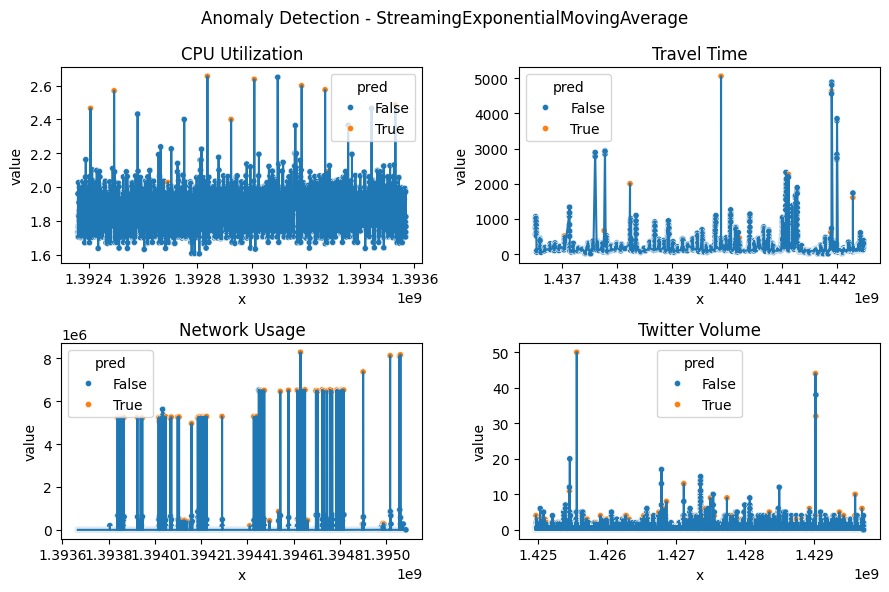

In [35]:
algorithm = StreamingExponentialMovingAverage
parameters = {'threshold': 1.5, 'alpha': 0.5}
title = ['CPU Utilization', 'Network Usage', 'Travel Time', 'Twitter Volume']
plot_anomalies([cpu, network, traffic, twitter], algorithm, parameters, title)

Unfortunately, this algorithms presented a lot of anomalies in Twitter Volume data. This is happening because the volume decrease and increase quickly - causing this confusion in the algorithm. What can we do? 
- We can raise the `threshold`, to increase limit for the anomalies; or
- We can raise the `threshold` and decrease the `alpha`, to increase the smoothness

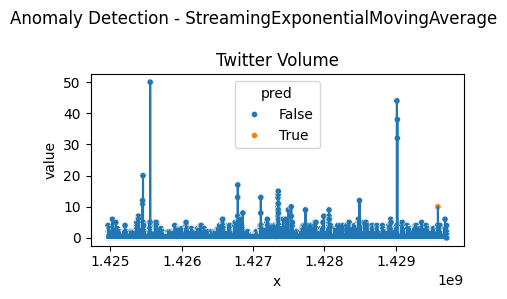

In [36]:
algorithm = StreamingExponentialMovingAverage
parameters = {'threshold': 1.6, 'alpha': 0.5}
title = ['Twitter Volume']
plot_anomalies([twitter], algorithm, parameters, title)

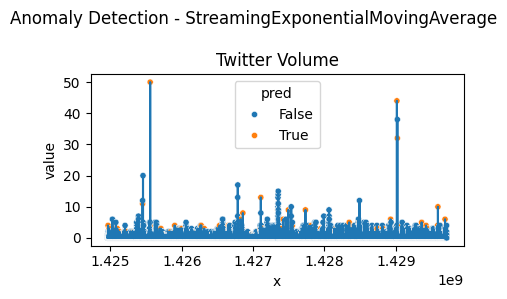

In [37]:
algorithm = StreamingExponentialMovingAverage
parameters = {'threshold': 1.8, 'alpha': 0.4}
title = ['Twitter Volume']
plot_anomalies([twitter], algorithm, parameters, title)
